1. For the model in the previous problem, use the correlation matrix formulation to find the equivalent external noise temperature, receiver noise temperature, system noise temperature, and the noise matching efficiency.

The thermal noise correlation matrix is:

$$ R_t = R_{ext} + R_{loss} $$

If we assume it's lossless then this reduces to

$$ R_t = R_{ext} $$

The thermail noise correlation matrix defined by Twiss's Theorem is

$$ R_{t,iso} = 8k_BT_{iso}B\Re[Z_A] $$

The equivalent noise distribution is given by equation 5.43:

$$ R_{ext} = 8k_BT_{ext}BA $$

By equating them we can reduce down to

$$ T_{ext} = \frac{T_{iso}}{2/|I_0|^2} $$

The receiver noise distribution is approximately to the nois distribution of the LNA. According to equation 5.62 the ratio of the LNA noise temperature and minimum noise temperature is given by:

$$ \frac{T_{LNA}}{T_{min}} = \frac{1}{2}(1+\frac{w^HAAw}{w^Hw}) $$

which can be used to get the LNA noise temperature. Then the system noise temperature is the sum of the noise source temperatures

$$ T_{sys} = T_{ext} + T_{LNA} = \frac{T_{iso}}{2/|I_0|^2} + T_{min}\frac{1}{2}(1+\frac{w^HAAw}{w^Hw}) $$

From that we can get the noise matching efficiency from 6.58

$$ \eta_n = \frac{T_{min}}{T_{iso}}


In [35]:
########### PREVIOUS ASSIGNMENT ############
########### IMPORTS #############
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi

########################################### VARIABLES ############################################
# Define antenna parameters
f = 300e6                 # Frequency in Hz
c = 3e8                 # Speed of light in m/s
lam = c / f             # Wavelength in m
k = 2 * np.pi / lam     # Wave number
eta = 377               # Intrinsic impedance of free space
Pel = 1                 # Radiated power
r = 1                   # Observation distance
l = lam / 2             # Half-wave dipole length
Im = 1                  # Mutual impedance
theta = np.pi/2        # broadside or endfire
phi = np.pi/2           # parallel to the array axis

# Define element spacing range
num_points = 100
d_values = np.array([lam/2])
# Number of elements in the array
N = 4

# system noise
T0 = 290  # Reference temperature in Kelvin
kB = 1.380649e-23  # Boltzmann constant in J/K
BW = 1e6  # Bandwidth in Hz
Tsys = T0*kB*BW  # System noise temperature in Kelvin

# sensitivity
sensitivity = 0

# SNR
SNR = 0

# overlap matrix 
A = np.zeros((N, N))

# uniform weights
w = np.array([1, 1, 1, 1])

# Initialize signal response
B = np.zeros((N, N), dtype=complex)     


################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements
    #print("rx \n", rx)                          # debug receiver positions

    ## compute the vector of phase shifted electric fields ##
    E0 = 1j * Im * eta / (2 * np.pi * r)                                          # Amplitude of the E-Field of a dipole on page 84
    E_el = E0 * (np.cos(k*l*np.cos(theta)/2)-np.cos(k*l/2)) / np.sin(theta) # E-field of a dipole
    Ep = np.zeros(N, dtype=complex)                                    # Initialize electric field
    # Ep loop for broadside
    for n in range(N):
        Ep[n] = E_el*np.exp(1j*k*d*np.sin(phi)*np.cos(theta)*(rx[n]-rx[0]))         # Compute electric field
    #print("Ep \n", Ep)                                                     # debug e-field

    ## compute the overlap matrix ##
    #A = np.zeros((N, N))                                          # initialize the overlap matrix
    points = 50
    for i in range(N):
        for j in range(N):
            # numerical implementation of the quadrature rule according to equations 4.69 and 4.70
            I = 0                                                 # initialize the integral
            del_phi = 2*np.pi/points                                   # integration weights
            del_theta = del_phi                                   # integration weights
            for m in range(points):
                phi_m = (m - 1/2) * del_phi                       # midpoint for each integration step
                for n in range(int(points/2)):
                    theta_n = (n - 1/2) * del_theta               # midpoint for each integration step

                    # integrand
                    Em = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[i])
                    En = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[j])

                    I += Em * np.conj(En) * np.sin(theta_n) * del_phi * del_theta   # integral approximation
                    #print("I\n", I)                               # debug integral                     
            #print("I \n", I)                                      # debug integral                                 

            A[i, j] = I                                           # assign the value of the integral to the overlap matrix
    
    ## compute the mutual impedance matrix ##
    A = A / (2*eta)
    scalar = 2/np.abs(Im)**2    # Equation 4.108
    Za = scalar * A             # mutual impedance matrix
    #print(Za)                   # debug mutual impedance matrix
          
    ## Compute weights ##
    A_inv = np.linalg.inv(A)    # invert overlap       
    #w = np.dot(A_inv, Ep)      # Compute weights equation 4.86
    #print("weights \n", w)     # debug weights
    
    ## compute signal response ##
    for m in range(N):
        for n in range(N):
            B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66
    B = B / (2 * eta)                       # Normalize signal response
    #print("B \n", B)                        # debug signal response

    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2)                 # Compute directivity scalar
    wB = w_herm @ B
    numerator = wB @ w  
    wA = w_herm @ A
    denominator = wA @ w
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    #print("Directivity \n", D)                 # debug directivity

    # calculate sensitivity
    sensitivity = (10*np.log10(D / Tsys))
    #print(k*d)

    ## Noise Calculations ##
    # calculate signal relationship
    Rs = B
    # calculate noise relationship
    const = 16*kB*T0/np.abs(Im)**2
    Rn = const * B @ A
    numerator = w.conj().T @ Rs @ w
    denominator = w.conj().T @ Rn @ w
    SNR = numerator / denominator

print("Sensitivity (dB/K): ", np.abs(sensitivity))  # print sensitivity values
print("SNR (dB): ", 10 * np.log10(np.abs(SNR)))     # print SNR in dB

# given values
F_min = 2   # minimum noise figure in dB
Rn = 15     # noise resistance in ohms

# assumed values
mu = 1  # magnetic permeability

# basic values
omega = 2*np.pi*f               # angular frequency
Tmin = (10**(2/10)-1)*T0        # minimum noise temperature
I = np.identity(N)              # identity matrix
RA = 2*A/np.abs(Im)**2          # normalized mutual impedance matrix
Einc = -10e-5                   # incident electric field
Sinc = np.abs(Einc)**2/(2*eta)  # incident power density
RA11 = RA[0,0]                  # mutual impedance matrix element

# main formulas
c1 = 4*np.pi*1j*r*np.exp(1j*k*r)/(omega*mu*Im)  # constant c1
Rsig = 2*eta*Sinc*np.abs(c1)**2*B               # signal correlation matrix
#print("Rsig \n", Rsig)
Rlna = kB*BW*Tmin*RA11*(I+A@A.conj().T)         # LNA noise correlation matrix 
#print("Rlna \n", Rlna)
Rext = 16*kB*T0/np.abs(Im)**2*BW*A              # external noise correlation matrix
#print("Rext \n", Rext)

# SNR Calculation
numerator = w.conj().T @ Rsig @ w               # numerator of SNR equation
denominator = w.conj().T @ (Rlna+Rn+Rext) @ w   # denominator of SNR equation
SNR = numerator / denominator                   # SNR equation
print("SNR (dB): ", 10*np.log10(np.abs(SNR)))   # print SNR values

# sensitivity calculation
sensitivity = 4*np.pi*kB*BW*SNR/(lam**2*Sinc)                   # sensitivity equation
print("Sensitivity (dB/K): ", 10*np.log10(np.abs(sensitivity))) # print

C:\Users\tw443\AppData\Local\Temp\ipykernel_293060\3242345309.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i, j] = I                                           # assign the value of the integral to the overlap matrix


Sensitivity (dB/K):  150.35327011069438
SNR (dB):  174.50985555237875
SNR (dB):  -248.49322159345587
Sensitivity (dB/K):  -297.3265766677548


In [36]:
## Noise temperatures ##
T_iso = 290
T_ext = T_iso / (2/abs(Im)**2)
A_tilde = A / A[0,0]
print("A_tilde: ", A_tilde)
T_LNA = Tmin * (1 + (w.conj().T @ A_tilde @ A_tilde.conj().T @ w) / (w.conj().T @ w)) / 2
T_sys = T_ext + T_LNA
eta_n = Tmin/T_iso
print("T_ext: ", T_ext)
print("T_LNA: ", T_LNA)
print("T_sys: ", T_sys)
print("eta_n: ", eta_n)

A_tilde:  [[ 1.          0.55770363 -0.1714069  -0.30767236]
 [ 0.55770363  1.          0.55770363 -0.1714069 ]
 [-0.1714069   0.55770363  1.          0.55770363]
 [-0.30767236 -0.1714069   0.55770363  1.        ]]
T_ext:  145.0
T_LNA:  294.39790547079537
T_sys:  439.39790547079537
eta_n:  0.5848931924611136


 2. Change your model to scan the array element spacing from 0 to 2λ. Use equal weights at
 the open circuit reference plane. Plot (a) the directivity, (b) the array gain with external noise
 only and an isotropic radiator as reference in the broadside direction, and (c) the array gain
 with the full noise model and element 1 as reference.

The array gain for an isotropic radiator is given by

$$ G_a(\Omega)=\frac{4\pi r^2 w^H_{oc} B_p(r) w_{oc}}{w^H_{oc}Aw_{oc}} $$

Then for the full noise model and element 1 as the reference becomes

$$ G_a = \frac{1}{B^*_{p,11}}\frac{w^H_{oc}B_p(r)w_{oc}}{w^H_{oc}w_{oc}} $$

<>:111: SyntaxWarning: invalid escape sequence '\l'
<>:113: SyntaxWarning: invalid escape sequence '\l'
<>:111: SyntaxWarning: invalid escape sequence '\l'
<>:113: SyntaxWarning: invalid escape sequence '\l'
C:\Users\tw443\AppData\Local\Temp\ipykernel_293060\1610890027.py:111: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('d/\lambda')
C:\Users\tw443\AppData\Local\Temp\ipykernel_293060\1610890027.py:113: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Directivity vs d/\lambda')
C:\Users\tw443\AppData\Local\Temp\ipykernel_293060\1610890027.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i, j] = I                                           # assign the value of the integral to the overlap matrix


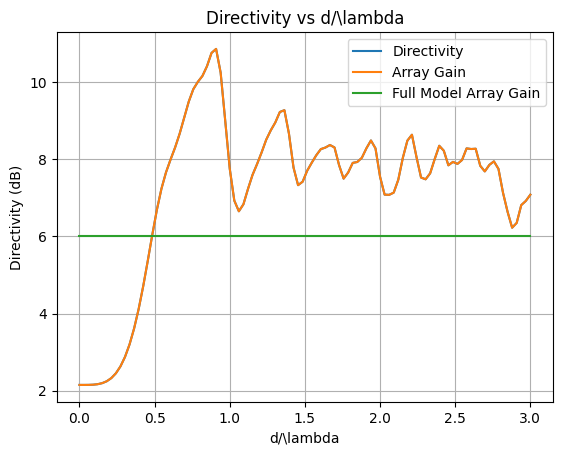

In [37]:
# Define element spacing range
num_points = 100
d_values = np.linspace(0, 3*lam, num_points)

# sensitivity
sensitivity = 0

# SNR
SNR = 0

# overlap matrix 
A = np.zeros((N, N))

# uniform weights
w = np.array([1, 1, 1, 1])

# Initialize signal response
B = np.zeros((N, N), dtype=complex)     

# save directivity and gain values
directivity = []
gains = []
full_gains = []

################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements
    #print("rx \n", rx)                          # debug receiver positions

    ## compute the vector of phase shifted electric fields ##
    E0 = 1j * Im * eta / (2 * np.pi * r)                                          # Amplitude of the E-Field of a dipole on page 84
    E_el = E0 * (np.cos(k*l*np.cos(theta)/2)-np.cos(k*l/2)) / np.sin(theta) # E-field of a dipole
    Ep = np.zeros(N, dtype=complex)                                    # Initialize electric field
    # Ep loop for broadside
    for n in range(N):
        Ep[n] = E_el*np.exp(1j*k*d*np.sin(phi)*np.cos(theta)*(rx[n]-rx[0]))         # Compute electric field
    #print("Ep \n", Ep)                                                     # debug e-field

    ## compute the overlap matrix ##
    #A = np.zeros((N, N))                                          # initialize the overlap matrix
    points = 50
    for i in range(N):
        for j in range(N):
            # numerical implementation of the quadrature rule according to equations 4.69 and 4.70
            I = 0                                                 # initialize the integral
            del_phi = 2*np.pi/points                                   # integration weights
            del_theta = del_phi                                   # integration weights
            for m in range(points):
                phi_m = (m - 1/2) * del_phi                       # midpoint for each integration step
                for n in range(int(points/2)):
                    theta_n = (n - 1/2) * del_theta               # midpoint for each integration step

                    # integrand
                    Em = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[i])
                    En = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[j])

                    I += Em * np.conj(En) * np.sin(theta_n) * del_phi * del_theta   # integral approximation
                    #print("I\n", I)                               # debug integral                     
            #print("I \n", I)                                      # debug integral                                 

            A[i, j] = I                                           # assign the value of the integral to the overlap matrix
    
    ## compute the mutual impedance matrix ##
    A = A / (2*eta)
    scalar = 2/np.abs(Im)**2    # Equation 4.108
    Za = scalar * A             # mutual impedance matrix
    #print(Za)                   # debug mutual impedance matrix
          
    ## Compute weights ##
    A_inv = np.linalg.pinv(A)    # invert overlap       
    #w = np.dot(A_inv, Ep)      # Compute weights equation 4.86
    #print("weights \n", w)     # debug weights
    
    ## compute signal response ##
    for m in range(N):
        for n in range(N):
            B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66
    B = B / (2 * eta)                       # Normalize signal response
    #print("B \n", B)                        # debug signal response

    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2)                 # Compute directivity scalar
    wB = w_herm @ B
    numerator = wB @ w  
    wA = w_herm @ A
    denominator = wA @ w
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    #print("Directivity \n", D)                 # debug directivity
    directivity.append(D)

    # calculate Array Gain
    array_gain = 4*np.pi*r**2 * (w.conj().T @ B @ w) / (w.conj().T @ A @ w) 
    gains.append(array_gain)

    # full model array gain
    full_gain_model = (w.conj().T @ B @ w) / (w.conj().T @ w) / B.conj()[0,0]
    full_gains.append(full_gain_model)




################################################## PLOTS ##########################################################
plt.figure()
plt.plot(d_values/lam, 10*np.log10(directivity))
plt.plot(d_values/lam, 10*np.log10(gains))
plt.plot(d_values/lam, 10*np.log10(full_gains))
plt.legend(['Directivity', 'Array Gain', 'Full Model Array Gain'])
plt.xlabel('d/\lambda')
plt.ylabel('Directivity (dB)')
plt.title('Directivity vs d/\lambda')
plt.grid()
plt.show()

 3. Redo the previous problem with the beamformer weights that maximize each quantity and
 plot the same curves. For small element spacings, the maximum directivity is a lot higher
 than the directivity with equal weights. But the maximum array gain with full noise model
 and element 1 as reference isn’t much larger than the array gain with equal weights. What’s
 going on?

<>:108: SyntaxWarning: invalid escape sequence '\l'
<>:110: SyntaxWarning: invalid escape sequence '\l'
<>:108: SyntaxWarning: invalid escape sequence '\l'
<>:110: SyntaxWarning: invalid escape sequence '\l'
C:\Users\tw443\AppData\Local\Temp\ipykernel_293060\963703292.py:108: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('d/\lambda')
C:\Users\tw443\AppData\Local\Temp\ipykernel_293060\963703292.py:110: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Directivity vs d/\lambda')
C:\Users\tw443\AppData\Local\Temp\ipykernel_293060\963703292.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i, j] = I                                           # assign the value of the integral to the overlap matrix
C:\Users\tw443\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  re

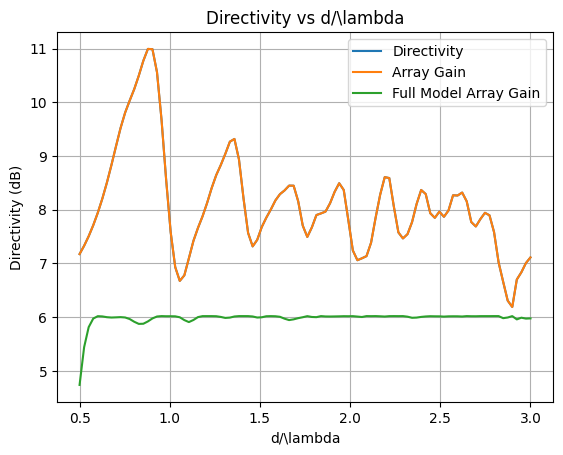

In [39]:
# Define element spacing range
num_points = 100
d_values = np.linspace(0.5*lam, 3*lam, num_points)

# sensitivity
sensitivity = 0

# SNR
SNR = 0

# overlap matrix 
A = np.zeros((N, N))

# Initialize signal response
B = np.zeros((N, N), dtype=complex)     

# save directivity and gain values
directivity = []
gains = []
full_gains = []

################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements
    #print("rx \n", rx)                          # debug receiver positions

    ## compute the vector of phase shifted electric fields ##
    E0 = 1j * Im * eta / (2 * np.pi * r)                                          # Amplitude of the E-Field of a dipole on page 84
    E_el = E0 * (np.cos(k*l*np.cos(theta)/2)-np.cos(k*l/2)) / np.sin(theta) # E-field of a dipole
    Ep = np.zeros(N, dtype=complex)                                    # Initialize electric field
    # Ep loop for broadside
    for n in range(N):
        Ep[n] = E_el*np.exp(1j*k*d*np.sin(phi)*np.cos(theta)*(rx[n]-rx[0]))         # Compute electric field
    #print("Ep \n", Ep)                                                     # debug e-field

    ## compute the overlap matrix ##
    #A = np.zeros((N, N))                                          # initialize the overlap matrix
    points = 50
    for i in range(N):
        for j in range(N):
            # numerical implementation of the quadrature rule according to equations 4.69 and 4.70
            I = 0                                                 # initialize the integral
            del_phi = 2*np.pi/points                                   # integration weights
            del_theta = del_phi                                   # integration weights
            for m in range(points):
                phi_m = (m - 1/2) * del_phi                       # midpoint for each integration step
                for n in range(int(points/2)):
                    theta_n = (n - 1/2) * del_theta               # midpoint for each integration step

                    # integrand
                    Em = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[i])
                    En = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[j])

                    I += Em * np.conj(En) * np.sin(theta_n) * del_phi * del_theta   # integral approximation
                    #print("I\n", I)                               # debug integral                     
            #print("I \n", I)                                      # debug integral                                 

            A[i, j] = I                                           # assign the value of the integral to the overlap matrix
    
    ## compute the mutual impedance matrix ##
    A = A / (2*eta)
    scalar = 2/np.abs(Im)**2    # Equation 4.108
    Za = scalar * A             # mutual impedance matrix
    #print(Za)                   # debug mutual impedance matrix
          
    ## Compute weights ##
    A_inv = np.linalg.pinv(A)    # invert overlap       
    w = np.dot(A_inv, Ep)      # Compute weights equation 4.86
    #print("weights \n", w)     # debug weights
    
    ## compute signal response ##
    for m in range(N):
        for n in range(N):
            B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66
    B = B / (2 * eta)                       # Normalize signal response
    #print("B \n", B)                        # debug signal response

    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2)                 # Compute directivity scalar
    wB = w_herm @ B
    numerator = wB @ w  
    wA = w_herm @ A
    denominator = wA @ w
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    #print("Directivity \n", D)                 # debug directivity
    directivity.append(D)

    # calculate Array Gain
    array_gain = 4*np.pi*r**2 * (w.conj().T @ B @ w) / (w.conj().T @ A @ w) 
    gains.append(array_gain)

    # full model array gain
    full_gain_model = (w.conj().T @ B @ w) / (w.conj().T @ w) / B.conj()[0,0]
    full_gains.append(full_gain_model)




################################################## PLOTS ##########################################################
plt.figure()
plt.plot(d_values/lam, 10*np.log10(directivity))
plt.plot(d_values/lam, 10*np.log10(gains))
plt.plot(d_values/lam, 10*np.log10(full_gains))
plt.legend(['Directivity', 'Array Gain', 'Full Model Array Gain'])
plt.xlabel('d/\lambda')
plt.ylabel('Directivity (dB)')
plt.title('Directivity vs d/\lambda')
plt.grid()
plt.show()